In [1]:
folder = '../Database/Ravi_Cancer_Cell_2022/10XVisium 2/#UKF241_C_ST/outs/spatial'

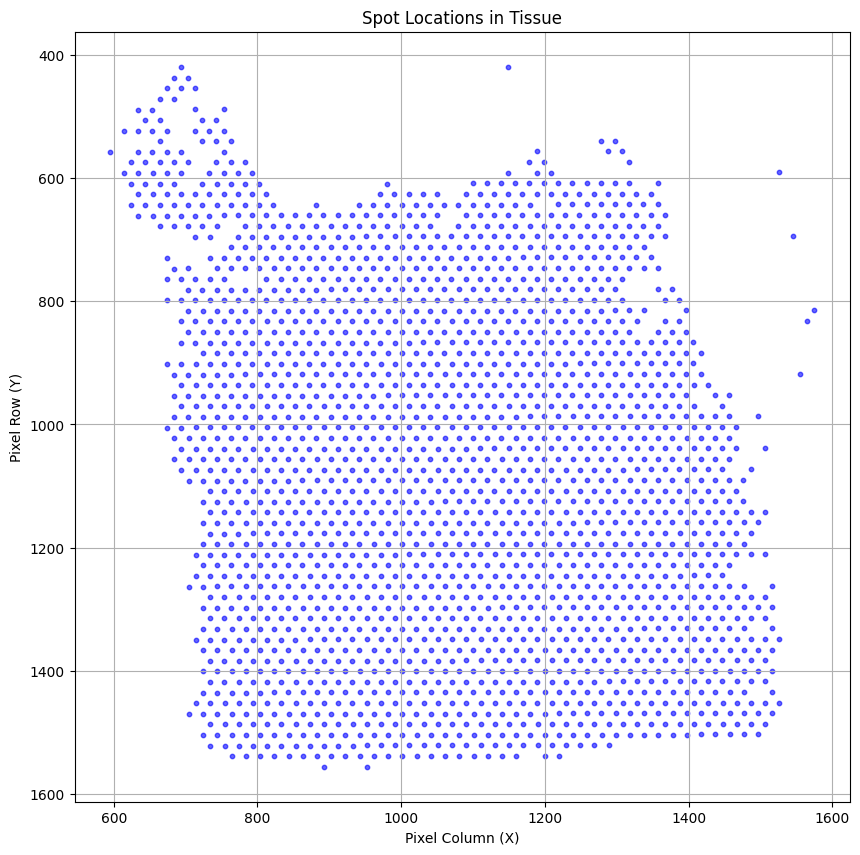

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일을 DataFrame으로 불러오기
df = pd.read_csv(folder + '/tissue_positions_list.csv', header=None)
df.columns = ['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']

# 조직 내에 있는 spot만 선택 (in_tissue == 1)
in_tissue_spots = df[df['in_tissue'] == 1]

# 위치 정보 가져오기 (pxl_row_in_fullres, pxl_col_in_fullres)
x_coords = in_tissue_spots['pxl_col_in_fullres']*0.24414062
y_coords = in_tissue_spots['pxl_row_in_fullres']*0.24414062

# 시각화
plt.figure(figsize=(10, 10))
plt.scatter(x_coords, y_coords, c='blue', alpha=0.6, s=10)
plt.gca().invert_yaxis()  # 이미지 좌표계와 맞추기 위해 Y축 반전
plt.title('Spot Locations in Tissue')
plt.xlabel('Pixel Column (X)')
plt.ylabel('Pixel Row (Y)')
plt.grid(True)
plt.show()


/tmp/ipykernel_102095/2254246771.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_tissue_spots['cell_count'] = cell_counts


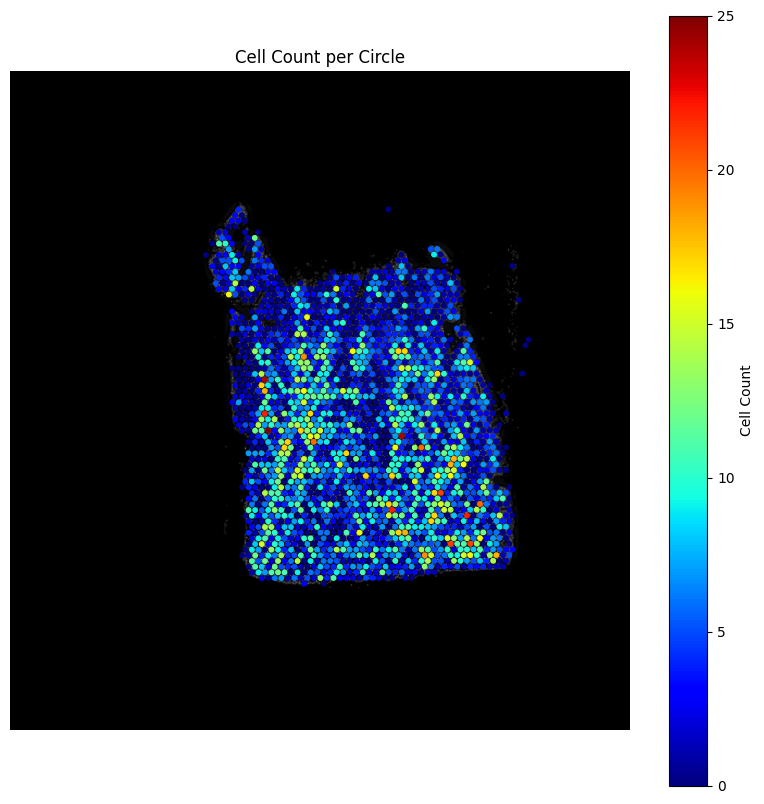

작업 완료: 'cell_counts_within_circles.csv' 파일에 결과가 저장되었습니다.
전체 spot의 세포 총 개수: 10774


In [91]:
import pandas as pd
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk

# 1. CSV 파일 및 이미지 파일 불러오기
csv_file = folder + '/tissue_positions_list.csv'
tif_file = folder + '/tissue_hires_image_Probabilities.tif'

# 좌표 데이터 불러오기
df = pd.read_csv(csv_file, header=None)  # 열 인덱스가 없으므로 header=None 설정
df.columns = ['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']

# 조직 내에 있는 spot만 선택 (in_tissue == 1)
in_tissue_spots = df[df['in_tissue'] == 1]

# 위치 정보 가져오기 (pxl_row_in_fullres, pxl_col_in_fullres)
x_coords = in_tissue_spots['pxl_col_in_fullres']*0.24414062
y_coords = in_tissue_spots['pxl_row_in_fullres']*0.24414062

# 이미지 파일 불러오기 (Ilastik 확률 맵)
probability_map = tiff.imread(tif_file)

# 결과 저장을 위한 리스트
cell_counts = []

# 2. 각 원에 대해 세포 개수 계산
diameter = 52.70366385405869*0.24414062
radius = diameter // 2

for x, y in zip(x_coords, y_coords):
    # 원의 좌표 계산 (원의 중심과 반지름을 이용하여)
    rr, cc = disk((y, x), radius, shape=probability_map.shape)
    
    # 3. 원 내부 픽셀의 확률 값 추출
    region = probability_map[rr, cc]

    # 4. 특정 임계값(예: 0.5)을 기준으로 세포가 있다고 간주
    threshold = 0.05
    cell_count = np.sum(region > threshold)
    cell_counts.append(cell_count)

# 5. 결과 리스트의 길이와 DataFrame의 길이를 맞추기 위해 padding 추가
while len(cell_counts) < len(in_tissue_spots):
    cell_counts.append(0)

# 결과를 새로운 CSV 파일로 저장
in_tissue_spots['cell_count'] = cell_counts
in_tissue_spots.to_csv('cell_counts_within_circles.csv', index=False, header=False)

# 6. 각 원의 위치와 세포 수를 시각화 (color로 표시)
plt.figure(figsize=(10, 10))
if probability_map.ndim == 3:
    plt.imshow(probability_map[:, :, 0], cmap='gray')  # 첫 번째 채널만 시각화
else:
    plt.imshow(probability_map, cmap='gray')
plt.scatter(x_coords, y_coords, c=cell_counts, cmap='jet', s = 10,)
plt.colorbar(label='Cell Count')
plt.title('Cell Count per Circle')
plt.axis('off')
plt.show()


print("작업 완료: 'cell_counts_within_circles.csv' 파일에 결과가 저장되었습니다.")

# 6. 전체 spot의 세포 개수를 계산하여 출력
total_cell_count = sum(cell_counts)
print(f"전체 spot의 세포 총 개수: {total_cell_count}")


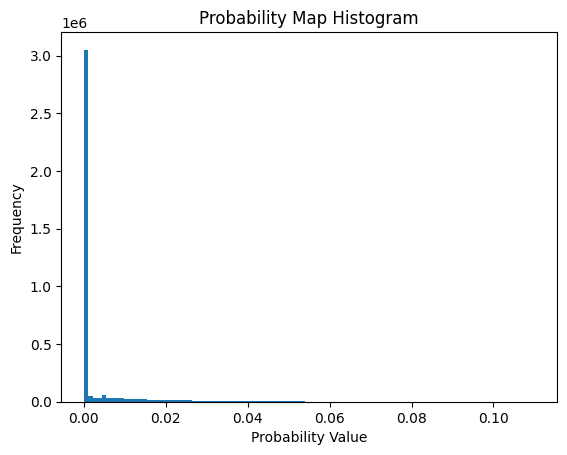

In [71]:
plt.hist(probability_map.flatten(), bins=100)
plt.title('Probability Map Histogram')
plt.xlabel('Probability Value') 
plt.ylabel('Frequency')
plt.show()

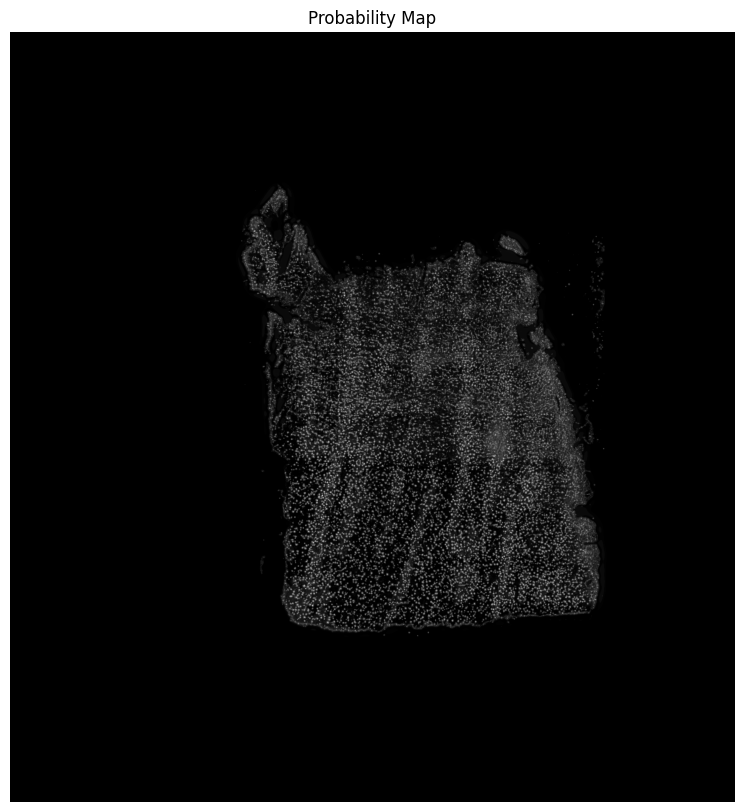

In [88]:
# 이미지 시각화 (확인용)
plt.figure(figsize=(10,10))
if probability_map.ndim == 3 and probability_map.shape[2] == 2:
    plt.imshow(probability_map[:, :, 0], cmap='gray')  # 첫 번째 채널만 시각화
else:
    plt.imshow(probability_map, cmap='gray')
plt.title('Probability Map')
plt.axis('off')
plt.show()